In [6]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/SparseCCSA/examples`


In [87]:
using SparseCCSA
using ProfileView
using LinearAlgebra
using SparseArrays
using CairoMakie
using ModelingToolkit
using Optimization
using NLopt
using OptimizationNLopt
using OptimizationMOI

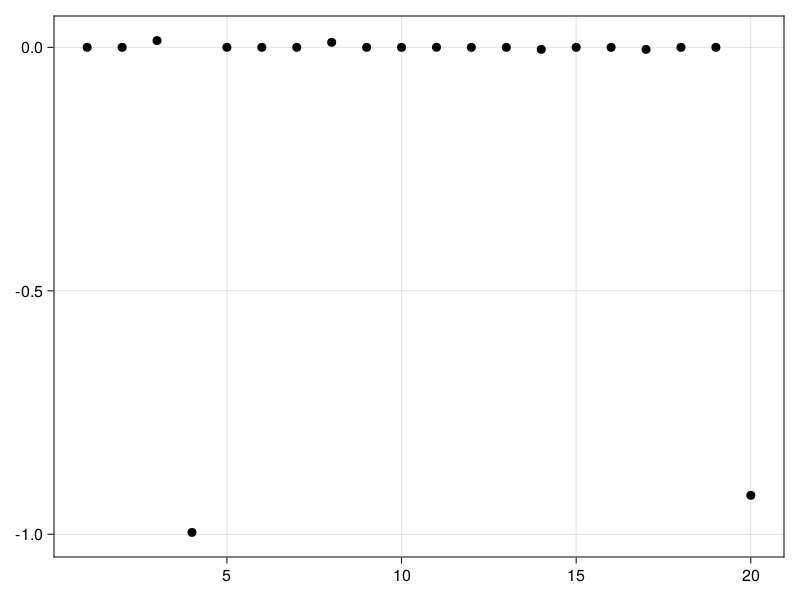

In [125]:
using Random: randperm
using Statistics: mean
using ImplicitAdjoints

n, p = 10, 20
S = 2
α = 0.1
β = 0
G = randn(n, p)
reg = L1(p)
u = zeros(p)
u[randperm(p)[1:S]] .= -1
η = randn(n)

function f(G, α, β)
    y = G * u
    y += 0.05 * mean(abs.(y)) * η
    uest, info = genlasso(G, y, α, β, 1000, 1e-12, reg)
end

y = G * u
y += 0.05 * mean(abs.(y)) * η

uest, info = f(G, α, β)
plot(uest)



In [126]:
u = rand(p)
t = abs.(u)
u_and_t = vcat(u, t)
# t_i >= u_i, t_i >= -u_i
# t_i - u_i >= 0, t_i + u_i >= 0

function obj(u_and_t, _)
    u = u_and_t[1:p]
    t = u_and_t[p+1:2p]
    sum((G * u - y).^2) + α * sum(t)
end

function grad(u_and_t)
    u = u_and_t[1:p]
    t = u_and_t[p+1:2p]
    grad_vec .= vcat(2 * G' * (G * u - y), fill(α, p))
end

function inst_grad(res, u_and_t)
    res .= grad(u_and_t)
end
    
function cons(u_and_t, _)
    u = u_and_t[1:p]
    t = u_and_t[p+1:2p]
    vcat(t - u, t + u)
end

func = OptimizationFunction{false}(obj, Optimization.AutoModelingToolkit(false, true); cons=cons, grad=inst_grad, cons_h=false, hess=false, hv=false)


(::OptimizationFunction{false, Optimization.AutoModelingToolkit, typeof(obj), typeof(inst_grad), Bool, Bool, typeof(cons), Nothing, Bool, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}) (generic function with 1 method)

In [127]:
func_inst = Optimization.instantiate_function(func, u_and_t, Optimization.AutoModelingToolkit(false, true), SciMLBase.NullParameters())

(::OptimizationFunction{true, Optimization.AutoModelingToolkit, typeof(obj), typeof(inst_grad), Bool, Bool, Optimization.var"#101#112"{OptimizationFunction{false, Optimization.AutoModelingToolkit, typeof(obj), typeof(inst_grad), Bool, Bool, typeof(cons), Nothing, Bool, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}, SciMLBase.NullParameters}, Optimization.var"#103#114"{SciMLBase.NullParameters, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xcf055014, 0x534a6806, 0x16403cf7, 0xe6775f96, 0xa98e757a)}}, Bool, Nothing, SparseMatrixCSC{Float64, Int64}, Vector{SparseMatrixCSC{Float64, Int64}}, Nothing, Nothing, Nothing, Nothing, Expr, Vector{Expr}}) (generic function with 1 method)

In [128]:
func_inst.cons_j(func_inst.cons_jac_prototype, u_and_t)

In [129]:
typeof(Inf)

Float64

In [130]:
lb = vcat(fill(-Inf, p), zeros(p))
ub = fill(Inf, 2p)
lcons = fill(0., 2p)
ucons = fill(Inf, 2p)

# toy_func = OptimizationFunction((x,_) -> (x[1]-2)^2, Optimization.AutoModelingToolkit())
# toy_prob = OptimizationProblem(toy_func, [3])
prob = OptimizationProblem(func, u_and_t; lb=lb, ub=ub, lcons=lcons, ucons=ucons)
sol = solve(prob, NLopt.Optimizer(); algorithm=:LD_CCSAQ)

u: 40-element Vector{Float64}:
 -3.5202068867554203e-13
 -1.9041864874703492e-10
  0.01402894733645374
 -0.9962602094949667
 -5.287009415200159e-11
  3.030865450009544e-9
  4.746850219241407e-12
  0.010237658688309434
 -3.609262700120659e-13
  1.2459167813631037e-11
  2.177102715411193e-6
 -1.131276525207776e-12
 -6.192057843349065e-9
  ⋮
  0.0
  0.0
  2.1771027123483325e-6
  0.0
  0.0
  0.004181677794971428
  0.0
  0.0
  0.0040906388793409375
  0.0
  0.0
  0.9199324484564153

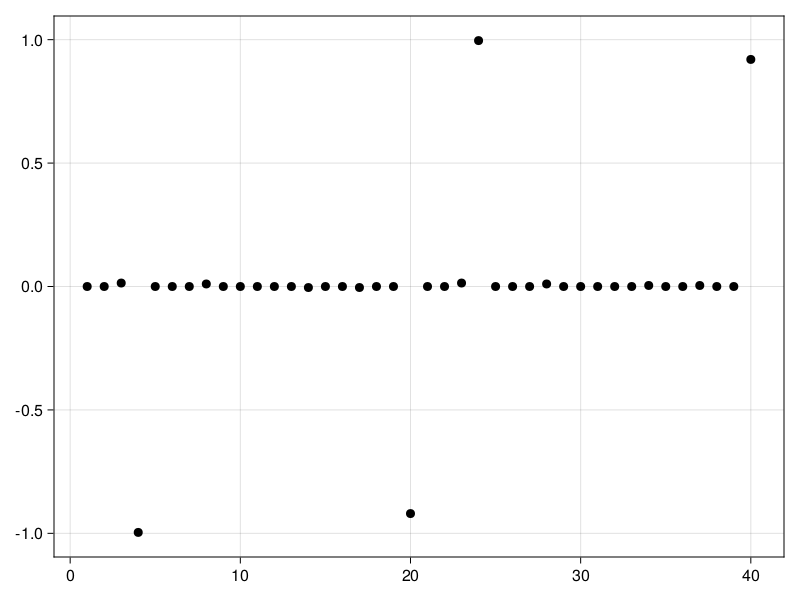

In [131]:
plot(sol)

In [28]:
NLopt.LD_CCSAQ

NLopt.LD_CCSAQ: CCSA (Conservative Convex Separable Approximations) with simple quadratic approximations (local, derivative)

In [4]:
α= 0.1
n= 100
A=sparse(Matrix(SymTridiagonal(2*ones(n),ones(n))))
x_true= ones(n)*10; x_true.= sprand(n,0.1)*10
y=A*x_true


100-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  6.248704339176672
 12.497408678353343
  8.02964468945121
  3.561880700549076
  1.780940350274538
  0.0

In [18]:
I=Vector{Int64}(undef,6n)
J=Vector{Int64}(undef,6n)
V=Vector{Float64}(undef,6n)
for i in 1:2n
    I[i]=1;J[i]=i; V[i]=α;
end
for i in 2n+1:3n
    I[i]=i-(2n-1); J[i]=i-(2n); V[i]=-1;
end
for i in 3n+1:4n
    I[i]=i-(3n-1); J[i]=i-(2n); V[i]=-1;
end
for i in 4n+1:5n
    I[i]=i-(3n-1); J[i]=i-(4n); V[i]=1;
end
for i in 5n+1:6n
    I[i]=i-(4n-1); J[i]=i-(4n); V[i]=-1;
end
∇f=sparse(I,J,V)

201×200 SparseMatrixCSC{Float64, Int64} with 600 stored entries:
⠻⣍⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠫⡍⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉⠉
⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠣⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠈⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠳⣄
⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠑⢆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠓⣄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢤⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠱⢄⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠑⢄

In [19]:
function creat_∇f(x)
    ∇f.nzval[1:3:3n-2].=A'*(A*(@view x[1:n])-y)
    return ∇f
end
f=Vector{Float64}(undef,2n+1)
function f_and_∇f(x)
    f = zeros(2n+1)
    f[1]=sum((A*(@view x[1:n])-y).^2)+α*sum(@view x[n+1:2n])
    for i in 1:n
        f[i+1]=-x[i]-x[i+n]
        f[i+n+1]=x[i]-x[i+n]
    end
    return f,creat_∇f(x)
end


f_and_∇f (generic function with 1 method)

In [30]:
max_iters=3
opt = CCSAState(2n, 2n, f_and_∇f,zeros(2n),max_iters=max_iters,xtol_rel=1e-4)
value=Array{Float64}(undef,1000)
recode_xi_stable=Array{Float64}(undef,2n,100)
function cb()
    value[opt.iters]=opt.fx[1]
    println(opt.iters)
    recode_xi_stable[:,opt.iters].=opt.x
end

cb (generic function with 1 method)

In [ ]:
optimize(opt; callback=cb)

1


In [ ]:
@time optimize(opt; callback=cb)


In [36]:
using Optimization

┌ Info: Precompiling Optimization [7f7a1694-90dd-40f0-9382-eb1efda571ba]
└ @ Base loading.jl:1342


In [37]:
OptimizationProblem

OptimizationProblem

In [39]:
OptimizationFunction

OptimizationFunction